In [2]:
import fastf1
import fastf1.plotting
from fastf1.ergast import Ergast
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import timedelta

In [3]:
year = 2025
race_number = 9

core           INFO 	Loading data for Spanish Grand Prix - Practice 1 [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '10', '12', '14', '16', '18', '22', '27', '30', '43', '44', '45', '50', '55', '63', '81', '87']
/home/kurios/Documents/f1_analysis/f1_analysis_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kurios/Documents/f1_analysis/f1_analysis_env/lib/python3.10/site-packages/numpy/lib/nanf

SOFT : + 0.0 s
MEDIUM : + 0.7 s
HARD : + 2.3 s
    Driver  Stint Compound  LapCount  FirstLap  LastLap  \
2      VER    3.0     SOFT         3       9.0     11.0   
3      VER    4.0     SOFT         7      12.0     18.0   
5      NOR    2.0     HARD         3       9.0     11.0   
6      NOR    3.0     SOFT         3      12.0     14.0   
7      NOR    4.0     SOFT         3      15.0     17.0   
..     ...    ...      ...       ...       ...      ...   
294    RUS    2.0     SOFT         9       5.0     13.0   
295    RUS    3.0     SOFT         3      14.0     16.0   
297    PIA    1.0   MEDIUM         3       2.0      4.0   
298    PIA    2.0   MEDIUM         5       5.0      9.0   
299    PIA    3.0     SOFT         3      10.0     12.0   

           fastest_laptime  number_quick_laptime       avg_quick_laptime  \
2   0 days 00:01:14.085000                   1.0  0 days 00:01:14.085000   
3   0 days 00:01:19.508000                   4.0  0 days 00:01:19.666000   
5   0 days 00:01

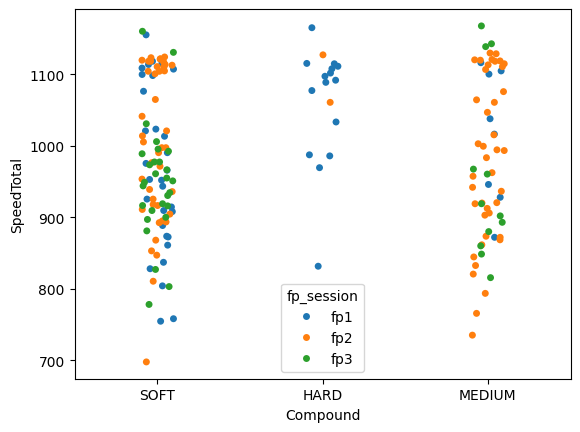

In [6]:
total_diff_medium = 0
total_diff_hard = 0
soft_i = 0
medium_i = 0
hard_i = 0
all_session_drivers_stints = pd.DataFrame()
for free_practice_session in ('fp1', 'fp2', 'fp3'):
    practice_session = fastf1.get_session(year, race_number, free_practice_session)
    practice_session.load(weather=True)
    drivers = pd.unique(practice_session.laps['Driver'])

    QUAL_LAP_PARAM = 1.03
    RACE_LAP_PARAM = 1.13

    laps = practice_session.laps
    stints = laps[["Driver", "Stint", "Compound", "LapNumber"]]
    stints = stints.groupby(["Driver", "Stint", "Compound"]).agg(
        LapCount=('LapNumber', 'count'),
        FirstLap=('LapNumber', 'min'),
        LastLap=('LapNumber', 'max')
    ).reset_index()

    laps_soft = practice_session.laps.pick_quicklaps(QUAL_LAP_PARAM)

    transformed_laps_soft = laps_soft.copy()
    transformed_laps_soft.loc[:, "LapTime (s)"] = laps_soft["LapTime"].dt.total_seconds()

    soft_laptime = transformed_laps_soft[transformed_laps_soft['Compound'] == 'SOFT']["LapTime (s)"].median()
    medium_laptime = transformed_laps_soft[transformed_laps_soft['Compound'] == 'MEDIUM']["LapTime (s)"].median()

    if pd.notna(soft_laptime) and pd.notna(medium_laptime):
        diff_soft_medium = medium_laptime - soft_laptime
        total_diff_medium += diff_soft_medium
        soft_i +=1
        medium_i +=1
    
    #hard
    laps_hard = practice_session.laps.pick_quicklaps(RACE_LAP_PARAM)

    transformed_laps_hard = laps_hard.copy()
    transformed_laps_hard.loc[:, "LapTime (s)"] = laps_hard["LapTime"].dt.total_seconds()

    medium_laptime = transformed_laps_hard[transformed_laps_hard['Compound'] == 'MEDIUM']["LapTime (s)"].median()
    hard_laptime = transformed_laps_hard[transformed_laps_hard['Compound'] == 'HARD']["LapTime (s)"].median()

   
    if pd.notna(medium_laptime) and pd.notna(hard_laptime):
        diff_medium_hard = hard_laptime - medium_laptime
        total_diff_hard +=diff_medium_hard
        medium_i +=1
        hard_i +=1

    fastest_lap_session = practice_session.laps.pick_fastest()['LapTime']
    
    all_stints_list = []
    for driver in drivers:
        driver_stints = stints[stints['Driver'] == driver].copy()
        for index, row in driver_stints.iterrows():
            driver_lap = practice_session.laps.pick_drivers(driver).pick_laps(range(int(row['FirstLap']), int(row['LastLap'])+1))
            driver_lap.loc[:, 'LapTime'] = driver_lap['LapTime'].fillna(driver_lap['Sector1Time'] + driver_lap['Sector2Time'] + driver_lap['Sector3Time'])
            driver_lap.loc[:, 'LapTime'] = driver_lap['LapTime'].fillna(driver_lap['Sector1Time'] + driver_lap['Sector2Time'] + driver_lap['Sector3Time'])
            driver_lap.loc[:, 'LapTime'] = driver_lap['LapTime'].fillna(driver_lap['Time'] - driver_lap['PitOutTime'])
            
            fastest_lap_driver = timedelta(seconds = driver_lap['LapTime'].dt.total_seconds().min())
            quick_laps = driver_lap[driver_lap['LapTime'] < fastest_lap_driver * QUAL_LAP_PARAM]
            avg_quick_laptime = quick_laps['LapTime'].median()
            number_quick_laptime = len(quick_laps['LapTime'])

            driver_stints.loc[index, 'fastest_laptime'] = fastest_lap_driver
            driver_stints.loc[index, 'number_quick_laptime'] = number_quick_laptime
            driver_stints.loc[index, 'avg_quick_laptime'] = avg_quick_laptime
            driver_stints.loc[index, 'fp_session'] = free_practice_session
            driver_stints.loc[index, 'SpeedTotal'] = driver_lap['SpeedI1'].median() + driver_lap['SpeedI2'].median() +  driver_lap['SpeedFL'].median() + driver_lap['SpeedST'].median()

            driver_stints['high_engine_mode'] = np.where(driver_stints['SpeedTotal'] > driver_stints['SpeedTotal'].quantile(q = [0.75]).values[0], 1, 0)
            driver_stints['low_engine_mode'] = np.where(driver_stints['SpeedTotal'] < driver_stints['SpeedTotal'].quantile(q = [0.25]).values[0], 1, 0)

        if not driver_stints.empty:
            driver_stints['quali_sim'] = np.where((driver_stints['avg_quick_laptime'] < driver_stints['fastest_laptime'].min()*QUAL_LAP_PARAM) & (driver_stints['avg_quick_laptime'] <= fastest_lap_session * QUAL_LAP_PARAM) & (driver_stints['Compound'] != 'HARD'), 1, 0)
            driver_stints['race_sim'] = np.where((driver_stints['avg_quick_laptime'] > driver_stints['fastest_laptime'].min()*QUAL_LAP_PARAM) & (driver_stints['avg_quick_laptime'] < driver_stints['fastest_laptime'].min()*RACE_LAP_PARAM), 1, 0)
            all_stints_list.append(driver_stints)
        driver_stints = driver_stints.dropna()

    if all_stints_list:
        drivers_stints = pd.concat(all_stints_list, ignore_index=True)
        all_session_drivers_stints = pd.concat([all_session_drivers_stints, drivers_stints], ignore_index=True)
    else:
        drivers_stints = pd.DataFrame()

    drivers_stints = drivers_stints.drop_duplicates()

total_diff_medium = abs(round(total_diff_medium/min(soft_i, medium_i),1))
total_diff_hard = abs(round(total_diff_hard/min(hard_i, medium_i),1))
print('SOFT : + 0.0 s')
print('MEDIUM : +', total_diff_medium,'s')
print('HARD : +', total_diff_medium + total_diff_hard,'s')
all_session_drivers_stints_sim = all_session_drivers_stints[(all_session_drivers_stints['quali_sim'] == 1) | (all_session_drivers_stints['race_sim'] == 1)]
print(all_session_drivers_stints_sim)
laptimes_plot = sns.stripplot(all_session_drivers_stints_sim, x='Compound', y='SpeedTotal', hue='fp_session')

In [1]:
total_diff_medium = 0
total_diff_hard = 0
soft_i = 0
medium_i = 0
hard_i = 0
all_session_drivers_stints = pd.DataFrame()
for free_practice_session in ('fp1', 'fp2', 'fp3'):
    practice_session = fastf1.get_session(year, race_number, free_practice_session)
    practice_session.load(weather=True)
    drivers = pd.unique(practice_session.laps['Driver'])

    QUAL_LAP_PARAM = 1.03
    RACE_LAP_PARAM = 1.13

    laps = practice_session.laps
    stints = laps[["Driver", "Stint", "Compound", "LapNumber"]]
    stints = stints.groupby(["Driver", "Stint", "Compound"]).agg(
        LapCount=('LapNumber', 'count'),
        FirstLap=('LapNumber', 'min'),
        LastLap=('LapNumber', 'max')
    ).reset_index()

    laps_soft = practice_session.laps.pick_quicklaps(QUAL_LAP_PARAM)

    transformed_laps_soft = laps_soft.copy()
    transformed_laps_soft.loc[:, "LapTime (s)"] = laps_soft["LapTime"].dt.total_seconds()

    soft_laptime = transformed_laps_soft[transformed_laps_soft['Compound'] == 'SOFT']["LapTime (s)"].median()
    medium_laptime = transformed_laps_soft[transformed_laps_soft['Compound'] == 'MEDIUM']["LapTime (s)"].median()

    if pd.notna(soft_laptime) and pd.notna(medium_laptime):
        diff_soft_medium = medium_laptime - soft_laptime
        total_diff_medium += diff_soft_medium
        soft_i +=1
        medium_i +=1
    
    #hard
    laps_hard = practice_session.laps.pick_quicklaps(RACE_LAP_PARAM)

    transformed_laps_hard = laps_hard.copy()
    transformed_laps_hard.loc[:, "LapTime (s)"] = laps_hard["LapTime"].dt.total_seconds()

    medium_laptime = transformed_laps_hard[transformed_laps_hard['Compound'] == 'MEDIUM']["LapTime (s)"].median()
    hard_laptime = transformed_laps_hard[transformed_laps_hard['Compound'] == 'HARD']["LapTime (s)"].median()

    if pd.notna(medium_laptime) and pd.notna(hard_laptime):
        diff_medium_hard = hard_laptime - medium_laptime
        total_diff_hard +=diff_medium_hard
        medium_i +=1
        hard_i +=1

    fastest_lap_session = practice_session.laps.pick_fastest()['LapTime']
    
    all_stints_list = []
    for driver in drivers:
        driver_stints = stints[stints['Driver'] == driver].copy()
        for index, row in driver_stints.iterrows():
            driver_lap = practice_session.laps.pick_drivers(driver).pick_laps(range(int(row['FirstLap']), int(row['LastLap'])+1))
            driver_lap.loc[:, 'LapTime'] = driver_lap['LapTime'].fillna(driver_lap['Sector1Time'] + driver_lap['Sector2Time'] + driver_lap['Sector3Time'])
            driver_lap.loc[:, 'LapTime'] = driver_lap['LapTime'].fillna(driver_lap['Sector1Time'] + driver_lap['Sector2Time'] + driver_lap['Sector3Time'])
            driver_lap.loc[:, 'LapTime'] = driver_lap['LapTime'].fillna(driver_lap['Time'] - driver_lap['PitOutTime'])
            
            fastest_lap_driver = timedelta(seconds = driver_lap['LapTime'].dt.total_seconds().min())
            quick_laps = driver_lap[driver_lap['LapTime'] < fastest_lap_driver * QUAL_LAP_PARAM]
            avg_quick_laptime = quick_laps['LapTime'].mean()
            number_quick_laptime = len(quick_laps['LapTime'])

            driver_stints.loc[index, 'fastest_laptime'] = fastest_lap_driver
            driver_stints.loc[index, 'number_quick_laptime'] = number_quick_laptime
            driver_stints.loc[index, 'avg_quick_laptime'] = avg_quick_laptime
            driver_stints.loc[index, 'fp_session'] = free_practice_session
            driver_stints.loc[index, 'SpeedTotal'] = driver_lap['SpeedI1'].mean() + driver_lap['SpeedI2'].mean() +  driver_lap['SpeedFL'].mean() + driver_lap['SpeedST'].mean()

            driver_stints['high_engine_mode'] = np.where(driver_stints['SpeedTotal'] > driver_stints['SpeedTotal'].quantile(q = [0.75]).values[0], 1, 0)
            driver_stints['low_engine_mode'] = np.where(driver_stints['SpeedTotal'] < driver_stints['SpeedTotal'].quantile(q = [0.25]).values[0], 1, 0)
            driver_stints['quali_sim'] = np.where((driver_stints['avg_quick_laptime'] < driver_stints['fastest_laptime'].min()*QUAL_LAP_PARAM) & (driver_stints['avg_quick_laptime'] <= fastest_lap_session * QUAL_LAP_PARAM) & (driver_stints['Compound'] != 'HARD'), 1, 0)
            driver_stints['race_sim'] = np.where((driver_stints['avg_quick_laptime'] > driver_stints['fastest_laptime'].min()*QUAL_LAP_PARAM) & (driver_stints['avg_quick_laptime'] < driver_stints['fastest_laptime'].min()*RACE_LAP_PARAM), 1, 0)

        if not driver_stints.empty:
            all_stints_list.append(driver_stints)
        driver_stints = driver_stints.dropna()

    if all_stints_list:
        drivers_stints = pd.concat(all_stints_list, ignore_index=True)
        all_session_drivers_stints = pd.concat([all_session_drivers_stints, drivers_stints], ignore_index=True)
    else:
        drivers_stints = pd.DataFrame()

    drivers_stints = drivers_stints.drop_duplicates()

total_diff_medium = abs(round(total_diff_medium/min(soft_i, medium_i),1))
total_diff_hard = abs(round(total_diff_hard/min(hard_i, medium_i),1))
print('SOFT : + 0.0 s')
print('MEDIUM : +', total_diff_medium,'s')
print('HARD : +', total_diff_medium + total_diff_hard,'s')
all_session_drivers_stints_sim
all_session_drivers_stints_sim = all_session_drivers_stints[(all_session_drivers_stints['quali_sim'] == 1) | (all_session_drivers_stints['race_sim'] == 1)]
laptimes_plot = sns.stripplot(all_session_drivers_stints_sim, x='Compound', y='SpeedTotal', hue='fp_session')

NameError: name 'pd' is not defined